In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
cont_features =[]
disc_features =[]

for col in features:
    if train[col].dtype=='float64':
        cont_features.append(col)
    else:
        disc_features.append(col)
        
features = disc_features + cont_features

In [8]:
train[cont_features] = train[cont_features].astype('float32')
train[disc_features] = train[disc_features].astype('uint8')
train[target] = train[target].astype('uint8')

test[cont_features] = test[cont_features].astype('float32')
test[disc_features] = test[disc_features].astype('uint8')

In [9]:
test[features]

,f22,f43,f242,f243,f244,f245,f246,f247,f248,f249,...,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241
0,0,1,0,0,1,0,1,1,0,0,...,0.195952,0.227176,0.092359,0.152883,0.266000,0.006716,0.196959,0.022934,0.199017,0.150822
1,1,0,0,0,0,1,1,1,0,0,...,0.194892,0.203178,0.126690,0.128326,0.182899,0.003132,0.190789,0.195818,0.136427,0.200248
2,0,0,0,1,1,1,1,1,0,1,...,0.196512,0.205674,0.276899,0.194539,0.283591,0.005843,0.123439,0.199566,0.217159,0.229726
3,0,0,0,0,0,0,1,1,0,1,...,0.196870,0.207462,0.268194,0.263770,0.487931,0.008247,0.140777,0.042808,0.196403,0.166039
4,1,0,0,1,0,1,1,0,0,0,...,0.195016,0.199202,0.191478,0.126863,0.168593,0.319238,0.155194,0.205401,0.196158,0.327414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,1,0,0,0,0,0,1,0,...,0.195130,0.199618,0.091413,0.162236,0.309894,0.011023,0.142858,0.521894,0.222184,0.251195
499996,0,0,0,0,1,1,0,1,0,0,...,0.197064,0.199442,0.748071,0.194264,0.207866,0.006372,0.175386,0.198387,0.142845,0.214146
499997,1,0,0,0,0,1,1,1,0,1,...,0.324317,0.197398,0.184333,0.136267,0.164835,0.006861,0.141225,0.044007,0.141896,0.228734
499998,0,0,0,0,0,0,1,1,0,0,...,0.195557,0.202305,0.039359,0.189006,0.239799,0.005881,0.192076,0.199732,0.169161,0.271750


In [10]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: uint8

# LGB

In [11]:
lgb_params = {
     'objective': 'binary',
     'n_estimators':N_ESTIMATORS,
     'importance_type': 'gain',
     'metric':'auc',
     'boosting_type': 'gbdt',
     'n_jobs' : -1,
        
    'learning_rate': 0.0038511441056118664, 
    'subsample': 0.5827550088149794, 
    'subsample_freq': 1, 
    'colsample_bytree': 0.19599597755538956, 
    'reg_lambda': 0.011685550612519125, 
    'reg_alpha': 0.04502045156737212, 
    'min_child_weight': 16.843316711276092, 
    'min_child_samples': 412, 
    'num_leaves': 546, 
    'max_depth': 5, 
    'cat_smooth': 36.40200359200525, 
    'cat_l2': 12.979520035205597
    }

In [12]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+1]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold == 4:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            lgb_params['random_state'] = inseed

            pre_model = lgb.LGBMClassifier(**lgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                categorical_feature = disc_features,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            lgb_params2 = lgb_params.copy()
            lgb_params2['reg_lambda'] *= 0.9
            lgb_params2['reg_alpha'] *= 0.9
            lgb_params2['learning_rate'] *= 0.1
            model = lgb.LGBMClassifier(**lgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    categorical_feature = disc_features,
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"lgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            lgb_importances = lgb_importances.append(fi_tmp)

            lgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            lgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, lgb_oof[val_idx])
        print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

lgb_pred /= N_SPLITS
print(f"oof lgb_auc = {roc_auc_score(train[target], lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.846338
[2000]	valid_0's auc: 0.84834
[3000]	valid_0's auc: 0.850289
[4000]	valid_0's auc: 0.851785
[5000]	valid_0's auc: 0.852955
[6000]	valid_0's auc: 0.853902
[7000]	valid_0's auc: 0.854634
[8000]	valid_0's auc: 0.85517
[9000]	valid_0's auc: 0.855583
[10000]	valid_0's auc: 0.8559
[11000]	valid_0's auc: 0.856123
[12000]	valid_0's auc: 0.856279
[13000]	valid_0's auc: 0.856411
[14000]	valid_0's auc: 0.856509
[15000]	valid_0's auc: 0.856576
[16000]	valid_0's auc: 0.85662
[17000]	valid_0's auc: 0.856648
[18000]	valid_0's auc: 0.856662
[19000]	valid_0's auc: 0.856668
Early stopping, best iteration is:
[18788]	valid_0's auc: 0.856671
Training until validation scores don't improve for 300 rounds
[19000]	valid_0's auc: 0.856671
[20000]	valid_0's auc: 0.856672
[21000]	valid_0's auc: 0.856673
Early stopping, best ite

# OOF predictions

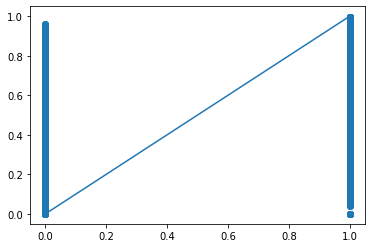

In [13]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

In [14]:
del train
del lgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'LGB feature importances')

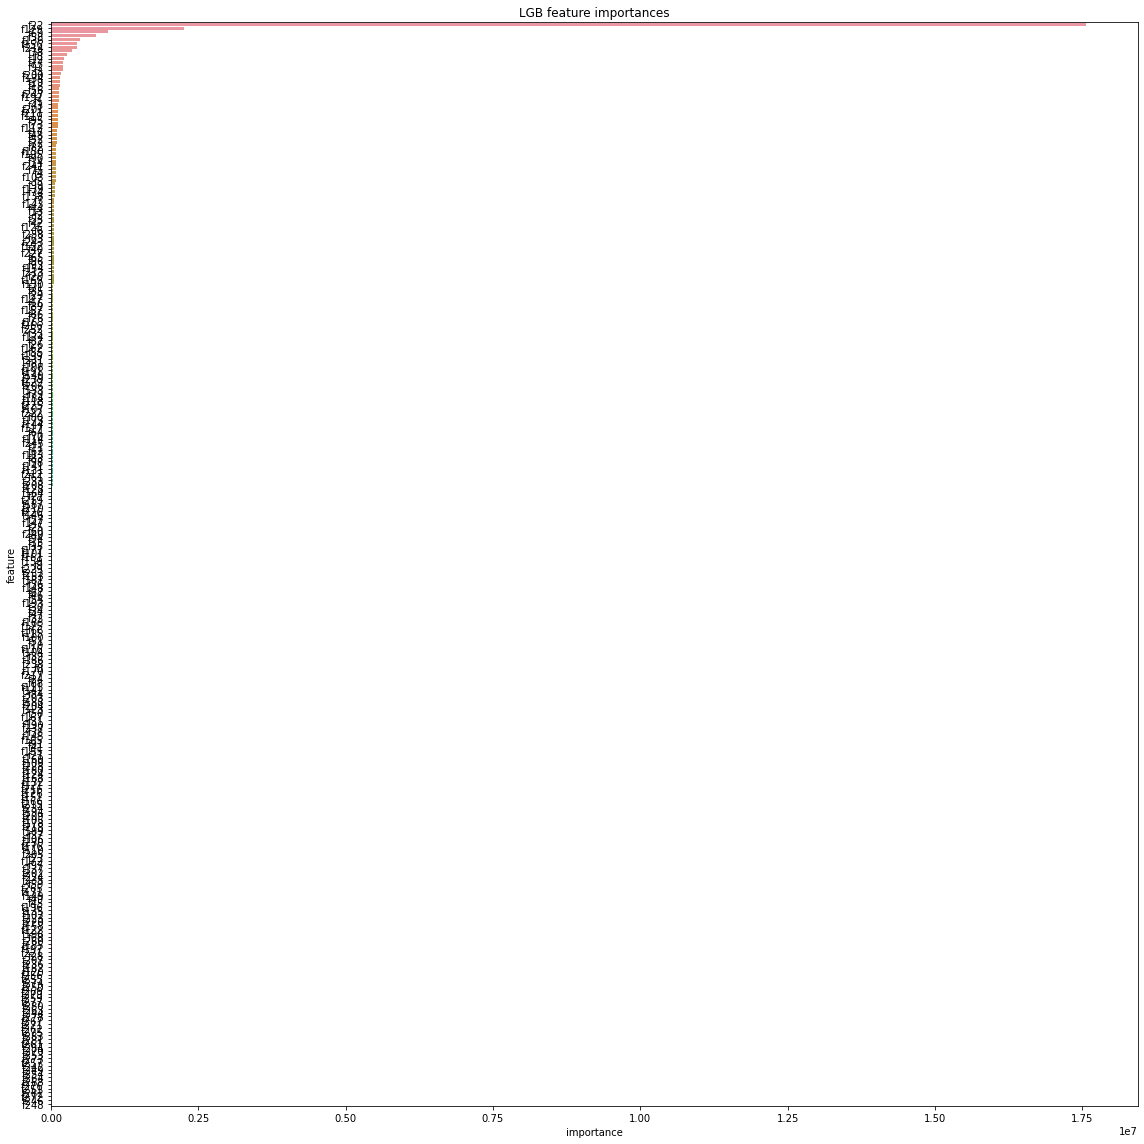

In [15]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LGB feature importances")

# Submission

In [16]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.143759
1,1000001,0.045991
2,1000002,0.180565
3,1000003,0.170625
4,1000004,0.050112
...,...,...
499995,1499995,0.192935
499996,1499996,0.165270
499997,1499997,0.059925
499998,1499998,0.102105


# Log

seeds

2017 ver1
2018 ver6 fold 0-3 ver7 fold 4 
2019 ver3
2020 ver4
2021 ver5